In [30]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, get_max_distance_to_target_surface, get_average_distance_to_target_surface, get_fixed_boundary_joint)
import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(24)
parallelism.set_hessian_assembly_num_threads(8)
parallelism.set_gradient_assembly_num_threads(8)

In [3]:
rod_length = 0.09933550935953463
width = rod_length / 20 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('kryptonite_1', thickness, width, weaving_dir)
# This is just to get a random surface

0.02483387733988366 0.0017383714137918559


In [17]:
io.SUBDIVISION_RESOLUTION = 40

In [18]:
OPTS = elastic_rods.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 5

### Initialization

In [32]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = False, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=InterleavingType.weaving)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions()
curved_linkage_view = linkage_vis.LinkageViewer(curved_linkage)
# set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [33]:
# curved_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, [thickness * 3, width * 3], stiffAxis=elastic_rods.StiffAxis.D1))


In [34]:
topColor =[79/255., 158/255., 246/255.]
bottomColor =[0.5, 0.5, 0.5]
heights = curved_linkage.visualizationGeometryHeightColors()
colors = np.take(np.array([bottomColor, topColor]), heights < heights.mean(), axis=0)

In [35]:
curved_linkage_view.update(scalarField=colors)

In [36]:
curved_linkage_view.setCameraParams(((4.139347366530763, -3.927678946178955, 0.7924706632167623),
 (-0.038125872037145875, 0.15887387844372028, 0.9865624707182293),
 (0.0, 0.0, 0.0)))

In [37]:
curved_linkage.attraction_weight = 0

In [47]:
iterateData = stage_1_optimization(curved_linkage, 0.1, 0.1, curved_linkage_view, niter = 100)

In [39]:
# curved_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, [thickness, width], stiffAxis=elastic_rods.StiffAxis.D1))

In [40]:
def eqm_callback(prob, i):
    curved_linkage_view.update(scalarField=colors)

In [41]:
boundary_vertices = get_fixed_boundary_joint(curved_linkage)

In [46]:
driver=curved_linkage.centralJoint()
jdo = curved_linkage.dofOffsetForJoint(driver)
fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
with so(): elastic_rods.compute_equilibrium(curved_linkage, fixedVars=fixedVars, callback = eqm_callback, options = OPTS)

In [44]:
# curved_save_tgt_joint_pos = curved_linkage.jointPositions()

In [132]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw)

In [133]:
optimizer.scaleJointWeights(1, 1, [])

In [134]:
optimizer.set_holdClosestPointsFixed(True)

In [135]:
optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, no_surface = True)

rl_regularization_weight 0.9999999999999999
smoothing_weight 5.0


Min Width  0.03
Scale:  166.66666666666669
num seg per rod 14
0.2


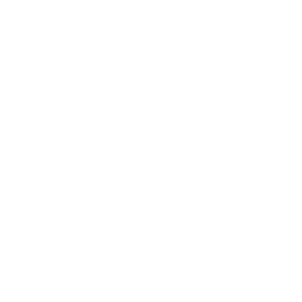

In [136]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False)
os.chdir(save_path)

## Contact Optimization

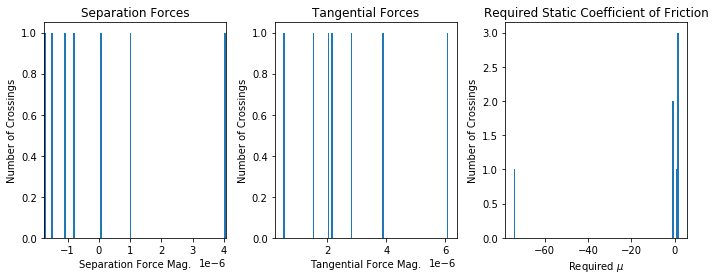

In [137]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [142]:
optimizer, opt_iterateData = contact_optimization(optimizer, curved_linkage, curved_linkage_view, -1, 1e8)

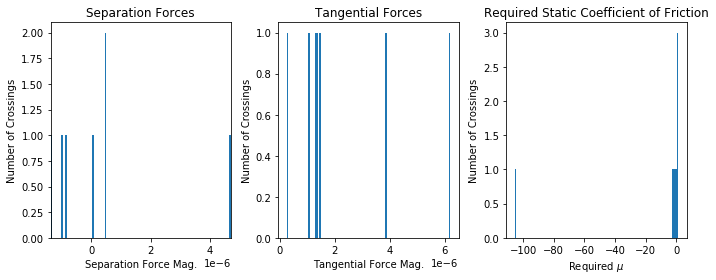

In [143]:
structure_view_2 = get_structure_analysis_view(curved_linkage)
structure_view_2.show()